# Manuscripts


We scrape the following two websites to get the manuscripts

- [imsdb](http://www.imsdb.com/)
- [springfieldspringfield](https://www.springfieldspringfield.co.uk/)
- [imsdb movie scripts](https://figshare.com/projects/imsdb_movie_scripts/18907)


In [27]:
# lets start by getting the data
import csv
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import json
import re
import os
import matplotlib.pyplot as plt
import operator
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
import operator
from math import log10, floor

# Function used to round numbers to n significant numbers
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [5]:
# Get data line by line from tmdb-5000-movie-database and save the data as dictionary

filepath = "/Users/GretarAtli/Documents/GitHub/Dtu/Dtu-SocialGraphs-FinalProject/Data/tmdb-5000-movie-dataset/tmdb_5000_credits.csv"
tmdb_5000_credits = defaultdict(dict)

with open(filepath) as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        tmdb_5000_credits[row["title"]] = row


In [48]:
# Get data line by line from tmdb-5000-movie-database and save the data as dictionary

filepath = "/Users/GretarAtli/Documents/GitHub/Dtu/Dtu-SocialGraphs-FinalProject/Data/tmdb-5000-movie-dataset/tmdb_5000_movies.csv"
tmdb_5000_movies = defaultdict(dict)

with open(filepath) as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        tmdb_5000_movies[row["title"]] = row
        # put the lists and dictonaries to a correct format, (that is not as string)
        tmdb_5000_movies[row["title"]]['genres'] = json.loads(tmdb_5000_movies[row["title"]]['genres'])
        tmdb_5000_movies[row["title"]]['keywords'] = json.loads(tmdb_5000_movies[row["title"]]['keywords'])
        tmdb_5000_movies[row["title"]]['production_companies'] = json.loads(tmdb_5000_movies[row["title"]]['production_companies'])
        
for title in sorted(tmdb_5000_movies.keys()):
    title = title.replace(" ","-").replace("(","").replace(")","")

## Get scripts from .txt files 


Fetching the scripts from the hard drive and check if the corresponding movie is a part of our main database. We want to find the size of the intersection to our database. In other words the number of scripts that correspond to a movie in our taggle database

In [8]:
filepath_scripts =  "/Users/GretarAtli/Dropbox/SocialGraph/scripts/"


# A python dictionary that maintains the information what movie has a manuscript in our database
manuscripts = defaultdict(bool)

for title in sorted(tmdb_5000_credits.keys()):
    title_for_uri = title.replace(" ","-").replace("(","").replace(")","")
    filename = filepath_scripts + title_for_uri + ".txt"
    try:
        #print (filename)
        f = open(filename,"r")
        manuscripts[title] = True
    except:
        manuscripts[title] = False

## Check intersection

We only want to make analysis on the movies that are part of the kaggle database. Therefore we start by finding the intersection between the scripts database and the kaggle database. In other words we want to find the movies that are part of both databases.

In [9]:
manuscripts_intersection = [key for key,value in manuscripts.items() if value == True]

In [10]:
print("Number of movies that are in both databases is: {} movies".format(len(manuscripts_intersection)))

Number of movies that are in both databases is: 686 movies


## Time span manuscripts

In [11]:
movies_with_manuscripts = [(key, tmdb_5000_movies[key]["release_date"].split("-")[0] ) 
                           for key,value in manuscripts.items() if value == True]

mwm_year_dist = Counter([year for _,year in movies_with_manuscripts])

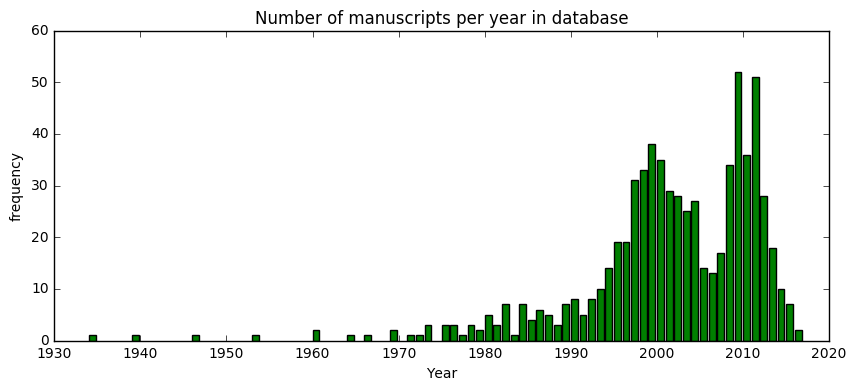

In [12]:
plt.figure(figsize=(10,4))
plt.bar(mwm_year_dist.keys(), mwm_year_dist.values(), color="green")
plt.xlabel("Year")
plt.ylabel("frequency")
plt.title("Number of manuscripts per year in database")
plt.show()

It can be seen here above that most of the manuscripts are from the period 1990 util 2015. 

# Sentiment Analysis

Now we have the scripts ready to do our sentiment analysis of the manuscripts. The first thing that is done is to get the happyness rank from the LabMT wordlist.  It's available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1).

We start of by getting the average happiness of each word in Data set S1 into a dictionary. We do this by reading dat set line by line and for each line (exept the first 4 lines) into a dictionary

The dataset as well as more information about how the average happyness value of each word in the dataset is calculated can be found by clicking on the following [link](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752#s2)

In [15]:
from collections import defaultdict

# counter to count the number of lines that have been processed
counter = 0

happyness_rank = defaultdict(float)
path = '/Users/GretarAtli/Documents/GitHub/Dtu/Dtu-SocialGraphs-FinalProject/Data/Data_Set_S1.txt'
with open(path) as f:
    for line in f:
        counter += 1
        
        # we want to skip the first 4 lines of the file
        if counter > 4:
            line = line.split()
            word = line[0]  # get the word from the line
            happiness_average = float(line[2]) # get the word happiness average
            happyness_rank[word] = happiness_average

In [16]:
import numpy as np

from __future__ import division

# Takes in a list of tokens and the happiness_keys which is the list of words in data set 1
# returns the mean value of the happiness rank that was found in the tokens array
# if no value was found then the function returns None
def estimateHappiness(tokens,happiness_keys):
    
    happiness_avg = [] # an array that contains the average happyness values of the tokens
    
    for token in tokens:
        # only include the words that can be found in the data set
        if token in happiness_keys: 
            happiness_avg.append(happyness_rank[token])
            
    # If no word in the tokens array is found in the dataset then we return 0
    if len(happiness_avg) == 0:
        return None
    else : 
        return np.mean(happiness_avg)

In [25]:
filepath_scripts =  "/Users/GretarAtli/Dropbox/SocialGraph/scripts/"


happiness_keys = set(happyness_rank.keys())

# Create a dictionary that is a container for the sensitivity analysis values
happiness_score = defaultdict(float)


counter = 0
for title in manuscripts_intersection:
    title_for_uri = title.replace(" ","-").replace("(","").replace(")","")
    filename = filepath_scripts + title_for_uri + ".txt"
    #print (filename)
    f = open(filename,"r")
    
    movie_text_tokens = []
    
    for line in f.readlines():
        # Clean the text by eliminating punctations 
        translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
        line = line.translate(translator)
        
        if not line.isupper():
            line = line.lower() # make the whole line lower case
            #tokenizer = RegexpTokenizer(r'\w+')  # We choose to use regularexpression tokenizer
            #line = tokenizer.tokenize(line) # Get all tokens with the tokenizer
            line = line.split()
            # filter out the stop words 
            #line = [w for w in line if not w in stopwords.words('english')] 

            # We decided to eliminate sentances if it only contains upper case letters. 
            # because we did not want to include the scene headings
            if line:
                #print (line)
                for word in line:
                    movie_text_tokens.append(word)
    
    happiness_score[title] = estimateHappiness(movie_text_tokens,happiness_keys)
    #break
    counter += 1
    #print(counter)

** Save the result to a file**

In [72]:
result_file_uri = "/Users/GretarAtli/Dropbox/SocialGraph/results/happiness-score.json"

with open(result_file_uri, 'w') as fp:
    json.dump(happiness_score, fp)


## Pre Analysing the result

We start our analysis by plotting um the average sentiment score for all of the 686 movie scripts that we are going to analyse

In [18]:
y, x = np.histogram(list(happiness_score.values()),100)

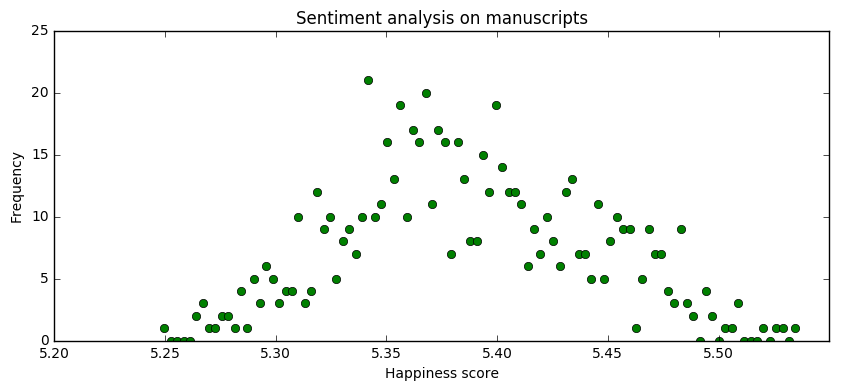

In [19]:
plt.figure(figsize=(10,4))
plt.plot(x[0:-1], y, 'o', color="green",)
plt.title("Sentiment analysis on manuscripts")
plt.ylabel("Frequency")
plt.xlabel("Happiness score")
plt.show()

- It can be seen that the average sentiment or happyness score of the movies forms a distribution that looks a lot like normal distribution. The values are all within quite narrow range, which is understandable because we are calculating the average sentiment of the movies over a whole manuscript. Therefore the values will all be dragged towards the average happyness score of the LabMT wordlist. However, the results still has some variance and we will analyse the difference further here down below. 
- It is interesting to see that the distribution seems to be inline with the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). 
- We decided to not delete the stopwords from the token list of each manuscript, the reason being that the LabMT wordlist contains stopwords and therefore, in our opinion, it does not make sens to excluse the informtion that the stopwords contain. 

**The ten 'happiest scripts' are : **

It is interesting to see what are the 10 movies that have the happiest vocabulary on average.

In [66]:
ten_happiest = sorted(happiness_score.items(), key=operator.itemgetter(1), reverse=True)[0:10]

print ("{movie_s: <35} {sentimentscore_s: <16} {genre_s: <14} ".format(
    movie_s = "Movie", sentimentscore_s = "Avg. score", genre_s = "Genres"))

print ("---------------------------------------------------------------------------------")

for key,value in ten_happiest:      
    # Create the genre string 
    genres = ""
    for genre in [genre['name'] for genre in tmdb_5000_movies[key]['genres']]:
        genres = genres + genre + " "
    
    print ("{movie_s: <35} {sentimentscore_s: <16}  {genre_s: <14}".format(
            movie_s =  key, 
            sentimentscore_s = round_sig(value,5),
            genre_s = genres
        ))


Movie                               Avg. score       Genres         
---------------------------------------------------------------------------------
Mary Poppins                        5.5375            Comedy Family Fantasy 
Boyhood                             5.5303            Drama         
Bridesmaids                         5.5273            Comedy Romance 
Her                                 5.5222            Romance Science Fiction Drama 
The Family Man                      5.5103            Comedy Drama Romance Fantasy 
Napoleon Dynamite                   5.5102            Comedy        
Precious                            5.5094            Drama         
The Perks of Being a Wallflower     5.5082            Drama Romance 
Rachel Getting Married              5.5039            Drama         
It's Complicated                    5.4989            Comedy Romance 


The result is not surprising and quite understandable. It can be seen that the movies with the highest average sentiment score are all so called "feel good movies" that we would in forehand expect to have quite happy vocabulary. This is something that we expected and it is nice to see that the result is in line with our intuition.

**The ten 'unhappiest scripts are:'**

It is also interesting to see what are the 10 movies that have the "unhappiest" vocabulary on average.

In [68]:
ten_happiest = sorted(happiness_score.items(), key=operator.itemgetter(1), reverse=False)[0:10]

print ("{movie_s: <35} {sentimentscore_s: <16} {genre_s: <14} ".format(
    movie_s = "Movie", sentimentscore_s = "Avg. score", genre_s = "Genres"))

print ("---------------------------------------------------------------------------------")

for key,value in ten_happiest:      
    # Create the genre string 
    genres = ""
    for genre in [genre['name'] for genre in tmdb_5000_movies[key]['genres']]:
        genres = genres + genre + " "
    
    print ("{movie_s: <35} {sentimentscore_s: <16}  {genre_s: <14}".format(
            movie_s =  key, 
            sentimentscore_s = round_sig(value,5),
            genre_s = genres
        ))

Movie                               Avg. score       Genres         
---------------------------------------------------------------------------------
Army of Darkness                    5.2498            Fantasy Horror Comedy 
Blade II                            5.265             Fantasy Horror Action Thriller 
Dawn of the Dead                    5.2655            Fantasy Horror Action 
Resident Evil                       5.268             Horror Action Science Fiction 
Predator                            5.2687            Science Fiction Action Adventure Thriller 
Cliffhanger                         5.269             Action Adventure Thriller 
Day of the Dead                     5.2699            Horror Science Fiction 
Alone in the Dark                   5.2748            Action Fantasy Horror Thriller 
The Thing                           5.2767            Horror Mystery Science Fiction 
Conan the Barbarian                 5.2769            Adventure Fantasy Action 


Again the result is as expected. The movies with the 'unhappiest' manuscript vocabulary are all movies that we could easily expect to have a negative vocabulary. These are all action or horror movies where the main storyline of the movie evolves around death or war. 

## Sentiment Vs Success of a movie 

To further analyse the sentiment, we wanted to find out if the sentiment has something to do with the success of the movie. We defined the success of both as the total gross earn by the movie and also the movie imdb score. To investigate this we simply investigated if there was any correlation between first sentiment of each movie versus the imdb score of the movie and secondly if there we a correlation between the sentiment and the total gross earn by the movie. 